## Inference in Tumor Growth Dynamics Under Immunotherapy
### Yazan Ghafir

The core objective of this project is to:

1- Turn raw MRI/CT scans into numbers (tumor volumes at each timepoint).

2- Fit stochastic growth models—equations that say on average the tumor grows at rate a, is checked by competition b, is slowed by immunization β, and is buffeted by random fluctuations σ —to those volume measurements.

3- Track the hidden tumor state over time using filters (Extended Kalman, Particle Filter).

4- Compare and validate which model best explains the data (via AIC/BIC, divergence measures, prediction errors).

5- Explore how noise intensity (σ) affects extinction probability and how immunization rate (β) shifts long‐term behavior.

These steps includes data preprocessing, parameter estimation, state estimation, and model validation.

In this project I am using the MU-Glioma-Post dataset available at https://www.cancerimagingarchive.net/collection/mu-glioma-post/ with 11GB of data.

## Imports

In [2]:
import os, time, re, zipfile
from pathlib import Path
import numpy as np
import pandas as pd
from numba import njit
from scipy import optimize, stats, signal
import matplotlib.pyplot as plt
import pywt, pymc as pm, arviz as az
import nibabel as nib
from skimage.filters import threshold_otsu
from concurrent.futures import ProcessPoolExecutor

# Reproducibility
RNG = np.random.default_rng(seed=42)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


## 1.1 Load dataset (PLEASE SKIP THIS IF LOADING DATA FROM CSV)
PKG‑MU‑Glioma‑Post from https://www.cancerimagingarchive.net/collection/mu-glioma-post/

In [ ]:
MASK = "_tumorMask.nii.gz"
PAT  = re.compile(r"(PatientID_\d+)_Timepoint_(\d+)")

def index_tp(root: str):
    rows = []
    for m in Path(root).rglob(f"*{MASK}"):
        if (r := PAT.match(m.name)):
            pid, tp = r.group(1), int(r.group(2))
            mods = {f"{t}_path": p.as_posix()
                    for t in ("t1c", "t1n", "t2f", "t2w")
                    if (p := m.parent / f"{pid}_Timepoint_{tp}_brain_{t}.nii.gz").exists()}
            rows.append({"patient": pid, "timepoint": tp,
                         "mask_path": m.as_posix(), **mods})
    return pd.DataFrame(rows)

def _vol(mask_path: str):
    n = nib.load(mask_path)
    return (n.get_fdata() > 0).sum() * np.prod(n.header.get_zooms()) / 1e3  # mm³→ml

def add_vol(df: pd.DataFrame):
    vols = {_p: _vol(_p) for _p in df.mask_path.unique()}
    df["volume_ml"] = df.mask_path.map(vols)
    return df

def build(root: str, n_scans: int = 4):
    df = index_tp(root)
    df = (df.groupby("patient")
            .filter(lambda g: g.timepoint.nunique() >= n_scans)
            .sort_values(["patient", "timepoint"])
            .groupby("patient").head(n_scans)
            .reset_index(drop=True))
    return add_vol(df)


# uncomment if downloaded the dataset

# root_dir = "PKG - MU-Glioma-Post"
# df4 = build(root_dir, n_scans=4)
# display(df4.head())

,patient,timepoint,mask_path,t1c_path,t1n_path,t2f_path,t2w_path,volume_ml
0,PatientID_0006,2,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,165.771
1,PatientID_0006,4,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,83.049
2,PatientID_0006,5,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,97.693
3,PatientID_0006,6,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,119.250
4,PatientID_0007,2,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,PKG - MU-Glioma-Post/MU-Glioma-Post/PatientID_...,48.582


### Plotting scans with masks for the first client in the dataset (PLEASE SKIP THIS IF LOADING DATA FROM CSV)

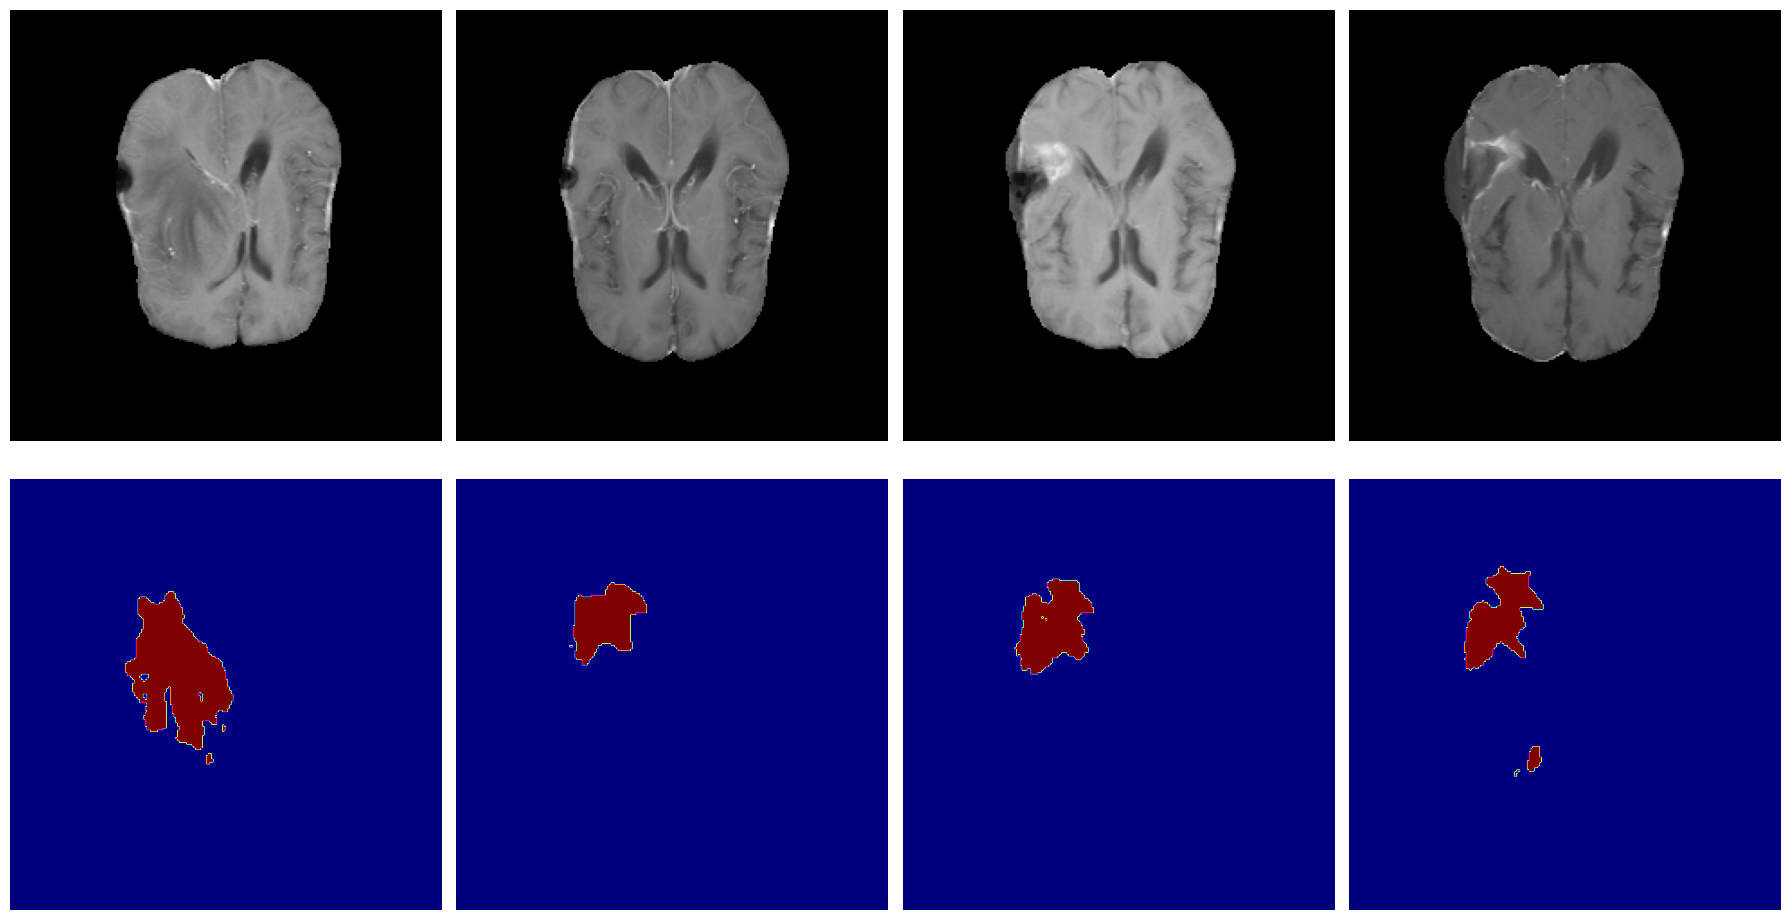

In [ ]:
# uncomment if downloaded the dataset

# import matplotlib.pyplot as plt, nibabel as nib
# cols=[c for c in df4.columns if c.endswith('_path') and c!='mask_path']
# s=df4.head(4)
# fig,ax=plt.subplots(2,4,figsize=(18,10))
# for i,r in enumerate(s.itertuples()):
#     z=nib.load(r._asdict()[cols[0]]).shape[2]//2
#     ax[0,i].imshow(nib.load(r._asdict()[cols[0]]).get_fdata()[...,z].T,cmap='gray',origin='lower');ax[0,i].axis('off')
#     ax[1,i].imshow((nib.load(r.mask_path).get_fdata()[...,z]>0).T,cmap='jet',origin='lower');ax[1,i].axis('off')
# plt.tight_layout();plt.show()

 (PLEASE START FROM HERE IF LOADING DATA FROM CSV)

In [ ]:
# load df4 from csv file if it exists
df4_path = Path("../data/PKG_MU-Glioma-Post.csv")
if df4_path.exists():
    df4 = pd.read_csv(df4_path)

Organise per‑patient series  (t relative, y = tumour volume ml)

In [7]:
def build_patient_series(df: pd.DataFrame):
    series = {}
    for pid, g in df.groupby("patient"):
        t_rel = g["timepoint"].to_numpy(dtype=float) - g["timepoint"].iloc[0]
        y_obs = g["volume_ml"].to_numpy(dtype=float)
        series[pid] = (t_rel, y_obs)
    return series

patient_data = build_patient_series(df4)
print(f"{len(patient_data)} patients with ≥4 scans loaded.")

59 patients with ≥4 scans loaded.


## 2.1 & 2.2 Mathematical Models (multiplicative noise and singular diffusion)

In [8]:
def drift(x, a, b, beta):
    """m = 2 drift shared by both models."""
    return (a - b * x) * x - beta * x**2 / (1 + x**2)

def diffusion_model1(x, sigma):
    return sigma * x                       # σ X_t

def diffusion_model2(x, sigma):
    return sigma * np.sqrt(np.maximum(x, 0.0))   # σ √X_t

## 3.1 Data Pre‑processing

### 3.1.1 Wavelet denoising for MRI artefact reduction

In [9]:
def wavelet_denoise(signal_1d, wavelet="db4", thresh_mode="soft"):
    coeffs = pywt.wavedec(signal_1d, wavelet)
    sigma_est = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma_est * np.sqrt(2 * np.log(len(signal_1d)))
    coeffs_filt = [pywt.threshold(c, uthresh, thresh_mode) for c in coeffs]
    return pywt.waverec(coeffs_filt, wavelet)[: len(signal_1d)]

df4["volume_denoised"] = df4.groupby("patient")["volume_ml"].transform(wavelet_denoise)

### 3.1.2 Parameter Estimation

In [10]:
# Euler‑Maruyama
def euler_maruyama(x0, params, T=20.0, dt=0.05, model=1):
    a, b, beta, sigma = params
    n = int(np.ceil(T / dt))
    t = np.linspace(0.0, n * dt, n + 1)
    x = np.empty_like(t)
    x[0] = x0
    sqrt_dt = np.sqrt(dt)
    for i in range(1, t.size):
        mu = drift(x[i - 1], a, b, beta)
        sigma_x = diffusion_model1(x[i-1], sigma) if model == 1 \
                  else diffusion_model2(x[i-1], sigma)
        x[i] = x[i - 1] + mu * dt + sigma_x * RNG.standard_normal() * sqrt_dt
        x[i] = max(x[i], 0.0)
    return t, x


# Variable‑Δt negative log‑likelihood & MLE
def neg_loglik_em_var_dt(params, x_obs, dt_vec, model=1):
    a, b, beta, sigma = params
    if any(p <= 0 for p in (a, b, sigma)) or beta < 0:
        return np.inf
    x_prev = x_obs[:-1]
    mu = drift(x_prev, a, b, beta)
    if model == 1:
        var = (sigma * x_prev) ** 2 * dt_vec
    else:
        var = (sigma * np.sqrt(np.maximum(x_prev, 0.0))) ** 2 * dt_vec
    resid = x_obs[1:] - x_prev - mu * dt_vec
    return 0.5 * np.sum(np.log(2 * np.pi * var) + resid**2 / var)

def fit_mle_var_dt(x_obs, dt_vec, model=1,
                   initial=(0.05, 0.005, 0.01, 0.05)):
    bounds = [(1e-4, 1.0), (1e-4, 1.0), (1e-5, 1.0), (1e-4, 1.0)]
    res = optimize.minimize(neg_loglik_em_var_dt, initial,
                            args=(x_obs, dt_vec, model),
                            method="L-BFGS-B", bounds=bounds)
    if not res.success:
        raise RuntimeError(res.message)
    return res.x, res.fun

#  Bayesian inference (PyMC) 
# PyMC posterior for a single patient (first in dict)
def pymc_posterior(x_obs, dt_vec, model=1, draws=1500, tune=1000):
    with pm.Model() as m:
        a     = pm.LogNormal("a",   mu=np.log(0.05), sigma=1.0)
        b     = pm.LogNormal("b",   mu=np.log(0.01), sigma=1.0)
        beta  = pm.LogNormal("beta",mu=np.log(0.02), sigma=1.0)
        sigma = pm.LogNormal("sigma",mu=np.log(0.05), sigma=1.0)

        mu = drift(x_obs[:-1], a, b, beta)
        if model == 1:
            var = (sigma * x_obs[:-1]) ** 2 * dt_vec
        else:
            var = (sigma * np.sqrt(np.maximum(x_obs[:-1], 0.0)))**2 * dt_vec
        pm.Normal("x_next", mu=x_obs[:-1] + mu * dt_vec,
                  sigma=np.sqrt(var), observed=x_obs[1:])
        return pm.sample(draws=draws, tune=tune,
                         target_accept=0.9, progressbar=True,
                         return_inferencedata=True)

pid0, (t0, y0) = next(iter(patient_data.items()))
idata = pymc_posterior(y0, np.diff(t0), model=1)
az.summary(idata)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 94 seconds.
There were 405 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.306,0.246,0.006,0.729,0.026,0.012,149.0,313.0,1.03
b,0.003,0.002,0.001,0.006,0.000,0.000,129.0,301.0,1.03
beta,0.032,0.042,0.001,0.095,0.001,0.003,540.0,2029.0,1.01
sigma,0.186,0.111,0.040,0.364,0.007,0.004,50.0,18.0,1.06


MLE parameters: {'a': 0.7141792373373079, 'b': 0.00577558553856627, 'beta': 1.0913826452436115e-05, 'sigma': 0.05312107637061626}


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 99 seconds.
There were 950 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,param,MLE,PostMean,HDI_low,HDI_high
0,a,0.714179,0.311743,0.002237,0.748106
1,b,0.005776,0.003166,0.000804,0.006352
2,beta,0.000011,0.031815,0.000886,0.087492
3,sigma,0.053121,0.182342,0.046973,0.355690


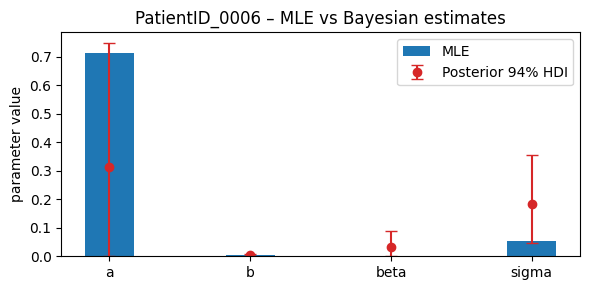

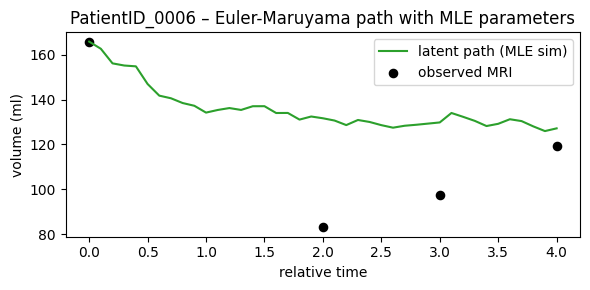

In [11]:
# %% ---------------------------------------------------------------------------
# MLE vs. Bayesian (PyMC) + Euler-Maruyama simulation for one patient
# ---------------------------------------------------------------------------
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------- 1. pick a patient & prepare data ---------------------------------
pid   = "PatientID_0006"                         # <-- choose any id you like
t_obs, y_obs = patient_data[pid]
dt_vec = np.diff(t_obs)

# ---------- 2. MLE via Euler-Maruyama likelihood -----------------------------
mle_params, mle_nll = fit_mle_var_dt(y_obs, dt_vec, model=1)
param_names = ["a", "b", "beta", "sigma"]
print("MLE parameters:", dict(zip(param_names, mle_params)))

# ---------- 3. Bayesian posterior with PyMC ----------------------------------
idata = pymc_posterior(y_obs, dt_vec, model=1, draws=2000, tune=1000)
post_mean = idata.posterior.mean(dim=("chain", "draw")).to_array("param").values
post_hdi  = az.hdi(idata, hdi_prob=0.94).to_array("param")

# ---------- 4. Euler-Maruyama simulation using MLE parameters ----------------
T_end = t_obs[-1]               # simulate up to last scan time
dt_sim = 0.1
t_sim, x_sim = euler_maruyama(y_obs[0], mle_params,
                              T=float(T_end), dt=dt_sim, model=1)

# ---------- 5. Tabulate & plot comparison ------------------------------------
df_cmp = pd.DataFrame({
        "param": param_names,
        "MLE":   mle_params,
        "PostMean": post_mean,
        "HDI_low": post_hdi.sel(hdi="lower"),
        "HDI_high": post_hdi.sel(hdi="higher")
})
display(df_cmp)

# --- bar / whisker figure -----------------------------------------------------
fig, ax = plt.subplots(figsize=(6,3))
ax.bar(df_cmp["param"], df_cmp["MLE"], width=0.35, label="MLE", color="tab:blue")
ax.errorbar(df_cmp["param"],
            df_cmp["PostMean"],
            yerr=[df_cmp["PostMean"]-df_cmp["HDI_low"],
                  df_cmp["HDI_high"]-df_cmp["PostMean"]],
            fmt="o", color="tab:red", capsize=4, label="Posterior 94% HDI")
ax.set_ylabel("parameter value")
ax.set_title(f"{pid} – MLE vs Bayesian estimates")
ax.legend()
plt.tight_layout()
plt.show()

# ---------- 6. Overlay simulated latent path vs observations -----------------
plt.figure(figsize=(6,3))
plt.plot(t_sim, x_sim, label="latent path (MLE sim)", lw=1.5, color="tab:green")
plt.scatter(t_obs, y_obs, c="k", s=35, label="observed MRI")
plt.xlabel("relative time"); plt.ylabel("volume (ml)")
plt.title(f"{pid} – Euler-Maruyama path with MLE parameters")
plt.legend(); plt.tight_layout(); plt.show()


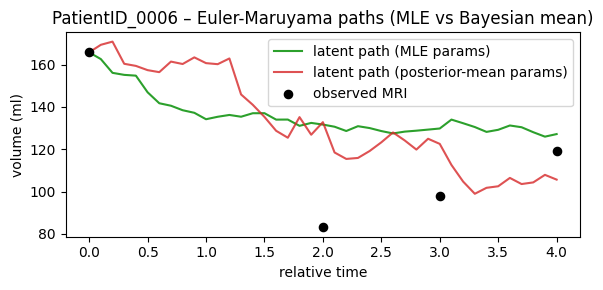

In [12]:
# ---------- 6. Overlay: MLE path  +  posterior-mean path --------------------
# simulate again with posterior mean parameters
t_sim_bayes, x_sim_bayes = euler_maruyama(
        y_obs[0], post_mean, T=float(T_end), dt=dt_sim, model=1)

plt.figure(figsize=(6,3))
plt.plot(t_sim,        x_sim,        lw=1.5, color="tab:green",
         label="latent path (MLE params)")
plt.plot(t_sim_bayes,  x_sim_bayes,  lw=1.5, color="tab:red", alpha=0.8,
         label="latent path (posterior-mean params)")
plt.scatter(t_obs, y_obs, c="k", s=35, zorder=5, label="observed MRI")
plt.xlabel("relative time"); plt.ylabel("volume (ml)")
plt.title(f"{pid} – Euler-Maruyama paths (MLE vs Bayesian mean)")
plt.legend(); plt.tight_layout(); plt.show()


## 3.1.3 State Estimation (Extended Kalman Filter (EKF)  & Particle Filter (PF))

In [13]:
def ekf_filter(y, dt, params, R=0.1**2, model=1, eps=1e-12):
    """
    Extended Kalman Filter with safeguards:
      • keeps variances ≥ eps
      • clips Kalman gain to [0,1] to avoid nan/neg.
    """
    a, b, beta, sigma = params
    n = len(y)
    x_f = np.zeros(n)
    P_f = np.zeros(n)

    x_f[0] = max(y[0], 1e-6)
    P_f[0] = 1.0

    for k in range(1, n):
        # ----- prediction ---
        mu     = drift(x_f[k-1], a, b, beta)
        x_pred = x_f[k-1] + mu * dt

        dfdx = (a - 2*b*x_f[k-1]) - beta * (
                2*x_f[k-1]/(1+x_f[k-1]**2) -
                2*x_f[k-1]**3/(1+x_f[k-1]**2)**2)

        q = (diffusion_model1(x_f[k-1], sigma) if model == 1
             else diffusion_model2(x_f[k-1], sigma))**2 * dt

        P_pred = max((1 + dfdx*dt)**2 * P_f[k-1] + q, eps)

        # ----- update ----
        K = np.clip(P_pred / (P_pred + R), 0.0, 1.0)     # Kalman gain
        x_f[k] = x_pred + K * (y[k] - x_pred)
        P_f[k] = (1 - K) * P_pred + eps                 # keep ≥ eps

    return x_f, P_f


def particle_filter(y, dt, params, Np=1000, R=0.1**2, model=1,
                    eps=1e-300):
    """
    Bootstrap Particle Filter with weight under-flow protection.

    * If all likelihoods under-flow ⇒ reset weights to uniform (avoids 0/0).
    * Adds `eps` before normalisation, preventing divide-by-zero warnings.
    """
    a, b, beta, sigma = params
    n = len(y)

    particles = np.clip(RNG.normal(y[0], 0.5, Np), 1e-6, None)
    weights   = np.full(Np, 1.0 / Np)
    means     = np.empty(n); means[0] = particles.mean()

    sqrt_R  = np.sqrt(R)
    sqrt_dt = np.sqrt(dt)

    for k in range(1, n):
        # ---- propagate ------------------------------------------------------
        mu = drift(particles, a, b, beta)
        sig = diffusion_model1(particles, sigma) if model == 1 \
              else diffusion_model2(particles, sigma)
        particles = np.clip(particles + mu*dt +
                            sig*RNG.standard_normal(Np)*sqrt_dt, 0.0, None)

        # ---- importance weights --------------------------------------------
        llh = stats.norm.pdf(y[k], loc=particles, scale=sqrt_R) + eps
        weights *= llh
        w_sum = weights.sum()

        if not np.isfinite(w_sum) or w_sum < eps:        # full under-flow
            weights.fill(1.0 / Np)
        else:
            weights /= w_sum

        # ---- systematic resample -------------------------------------------
        cdf = np.cumsum(weights)
        u0  = RNG.random() / Np
        idx = np.searchsorted(cdf, u0 + np.arange(Np) / Np)
        particles = particles[idx]
        weights.fill(1.0 / Np)

        means[k] = particles.mean()

    return means

## 3.4 Model Validation

In [14]:
# Information criteria, KL divergence, RMSE
def information_criteria(nll, k, n):
    return 2*k + 2*nll, k*np.log(n) + 2*nll  # (AIC, BIC)

def kl_divergence(p_samples, q_samples, bins="auto"):
    h_p, edges = np.histogram(p_samples, bins=bins, density=True)
    h_q, _     = np.histogram(q_samples, bins=edges, density=True)
    h_p = np.clip(h_p, 1e-12, None); h_q = np.clip(h_q, 1e-12, None)
    return stats.entropy(h_p, h_q)

def rmse(x_true, x_est):
    return np.sqrt(np.mean((x_true - x_est)**2))

## 3.5 Comparative Analysis  

### 3.5.1 Extinction probability vs σ 3.5.2 β‑sensitivity 3.5.3 Timing EKF vs PF

In [15]:
def extinction_probability(params, sigma_vec, T=50, dt=0.05,
                           model=1, n_paths=200, thresh=1e-3):
    a, b, beta, _ = params
    probs = []
    for s in sigma_vec:
        hits = 0
        for _ in range(n_paths):
            _, x = euler_maruyama(0.1, (a, b, beta, s), T, dt, model)
            hits += (x < thresh).any()
        probs.append(hits / n_paths)
    return np.array(probs)

def steady_state_samples(beta_val, params, T=200, dt=0.05,
                         n_paths=200, model=1):
    a, b, _, sigma = params
    samples = []
    for _ in range(n_paths):
        _, x = euler_maruyama(0.2, (a, b, beta_val, sigma), T, dt, model)
        samples.append(x[-1])
    return np.array(samples)

def timing_comparison(y_obs, dt, params, model=1, Np=1000):
    t0 = time.perf_counter()
    ekf_filter(y_obs, dt, params, model=model)
    t_ekf = time.perf_counter() - t0
    t0 = time.perf_counter()
    particle_filter(y_obs, dt, params, Np, model=model)
    t_pf = time.perf_counter() - t0
    return t_ekf, t_pf

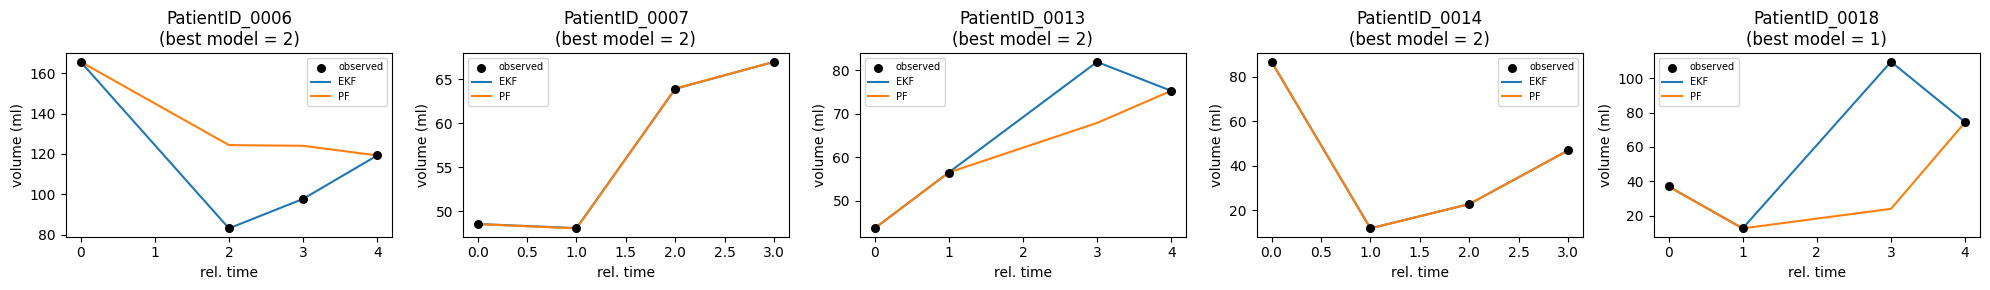

,patient,model,mle_a,mle_b,mle_beta,mle_sigma,rmse_ekf,rmse_pf
0,PatientID_0006,2,0.729003,0.005882,0.002094,0.508353,0.005203,24.514297
1,PatientID_0007,2,0.524899,0.007518,0.010438,0.951067,0.001300,0.024899
2,PatientID_0013,2,0.833718,0.010885,1.000000,0.224960,0.024752,7.035464
3,PatientID_0014,2,1.000000,0.020991,0.000010,1.000000,0.002809,0.021164
4,PatientID_0018,1,1.000000,0.009823,0.000010,1.000000,0.002687,42.761478


,patient,model,mle_a,mle_b,mle_beta,mle_sigma,rmse_ekf,rmse_pf
0,PatientID_0006,2,0.729003,0.005882,0.002094,0.508353,0.005203,24.514297
1,PatientID_0007,2,0.524899,0.007518,0.010438,0.951067,0.001300,0.024899
2,PatientID_0013,2,0.833718,0.010885,1.000000,0.224960,0.024752,7.035464
3,PatientID_0014,2,1.000000,0.020991,0.000010,1.000000,0.002809,0.021164
4,PatientID_0018,1,1.000000,0.009823,0.000010,1.000000,0.002687,42.761478


In [16]:
# %% ---------------------------------------------------------------------------
# Plot EKF and PF curves for the *first five* patients side-by-side
# ---------------------------------------------------------------------------
import matplotlib.pyplot as plt
from itertools import islice

n_show = 5                                      # how many patients to display
fig, axes = plt.subplots(1, n_show, figsize=(4*n_show, 3), sharey=False)

results = []                                    # keep the numeric summary
for ax, (pid, (t_obs, y_obs)) in zip(axes, islice(patient_data.items(), n_show)):

    # ---------- 1. choose best model via AIC -------------------------------
    dt_vec = np.diff(t_obs)
    mle1, nll1 = fit_mle_var_dt(y_obs, dt_vec, model=1)
    mle2, nll2 = fit_mle_var_dt(y_obs, dt_vec, model=2)
    aic1, _    = information_criteria(nll1, 4, len(y_obs))
    aic2, _    = information_criteria(nll2, 4, len(y_obs))
    best_model = 1 if aic1 < aic2 else 2
    best_mle   = mle1 if best_model == 1 else mle2

    # ---------- 2. run EKF and PF -----------------------------------------
    dt_const   = np.median(dt_vec)
    x_ekf, _   = ekf_filter(y_obs, dt_const, best_mle, model=best_model)
    x_pf       = particle_filter(y_obs, dt_const, best_mle, model=best_model)

    # ---------- 3. store numeric summary ----------------------------------
    results.append(dict(patient=pid, model=best_model,
                        mle_a=best_mle[0], mle_b=best_mle[1],
                        mle_beta=best_mle[2], mle_sigma=best_mle[3],
                        rmse_ekf=rmse(y_obs, x_ekf),
                        rmse_pf=rmse(y_obs, x_pf)))

    # ---------- 4. plot on its own axis -----------------------------------
    ax.scatter(t_obs, y_obs, s=30, label="observed", zorder=5, color="k")
    ax.plot(t_obs, x_ekf, lw=1.5, label="EKF", color="tab:blue")
    ax.plot(t_obs, x_pf,  lw=1.5, label="PF",  color="tab:orange")
    ax.set_title(f"{pid}\n(best model = {best_model})")
    ax.set_xlabel("rel. time")
    ax.set_ylabel("volume (ml)")
    ax.legend(fontsize=7)

plt.tight_layout()
plt.show()

# Convert results to a DataFrame if you want to inspect numerically
import pandas as pd
df_first5 = pd.DataFrame(results)
display(df_first5)

df_res = pd.DataFrame(results)
display(df_res)

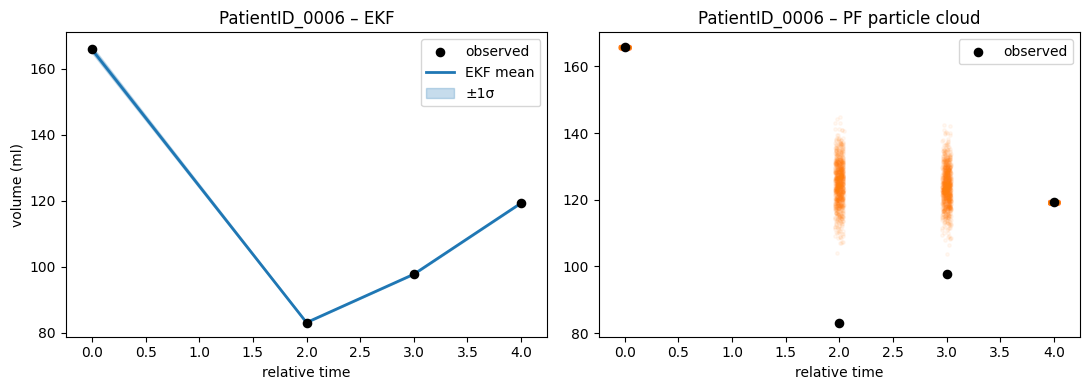

In [17]:
# %% ---------------------------------------------------------------------------
# EKF vs PF – final side-by-side plot with full particle cloud
# ---------------------------------------------------------------------------
import numpy as np, matplotlib.pyplot as plt

# ---------- choose a patient --------------------------------------------------
pid0          = df_res.iloc[0]["patient"]
t_obs, y_obs  = patient_data[pid0]
best_model    = int(df_res.set_index("patient").loc[pid0, "model"])
best_params   = df_res.set_index("patient").loc[pid0,
                    ["mle_a","mle_b","mle_beta","mle_sigma"]].to_numpy(float)
dt_const      = np.median(np.diff(t_obs))

# ---------- EKF mean and ±1σ band --------------------------------------------
x_ekf, P_ekf  = ekf_filter(y_obs, dt_const, best_params, model=best_model)
sigma_ekf     = np.sqrt(P_ekf)

# ---------- Particle filter that stores *all* particles -----------------------
def particle_filter_store(y, dt, params, Np=1000, R=0.1**2, model=1):
    a, b, beta, sigma = params
    n      = len(y)
    parts  = np.clip(RNG.normal(y[0], np.sqrt(R), size=Np), 1e-6, None)
    w      = np.full(Np, 1.0/Np)
    clouds = np.empty((n, Np))
    clouds[0] = parts
    sqrt_R, sqrt_dt = np.sqrt(R), np.sqrt(dt)

    for k in range(1, n):
        mu  = drift(parts, a, b, beta)
        sig = diffusion_model1(parts, sigma) if model == 1 \
              else diffusion_model2(parts, sigma)
        parts = np.clip(parts + mu*dt + sig*RNG.standard_normal(Np)*sqrt_dt,
                        0.0, None)

        w *= stats.norm.pdf(y[k], loc=parts, scale=sqrt_R)
        w_sum = w.sum()
        w = w / w_sum if w_sum > 0 else np.full(Np, 1.0/Np)

        # systematic resample
        cdf = np.cumsum(w)
        u0  = RNG.random()/Np
        idx = np.searchsorted(cdf, u0 + np.arange(Np)/Np)
        idx = np.minimum(idx, Np-1)          # guard against overflow
        parts = parts[idx]
        w.fill(1.0/Np)                       # reset weights

        clouds[k] = parts

    return clouds

clouds_pf = particle_filter_store(y_obs, dt_const, best_params,
                                  Np=1000, model=best_model)

# ---------- plotting ----------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(11, 4), sharex=True)

# 1) EKF panel ------------------------------------------------
ax[0].scatter(t_obs, y_obs, s=35, label="observed", zorder=5, color="k")
ax[0].plot(t_obs, x_ekf, lw=2, label="EKF mean", color="tab:blue")
ax[0].fill_between(t_obs, x_ekf - sigma_ekf, x_ekf + sigma_ekf,
                   color="tab:blue", alpha=0.25, label="±1σ")
ax[0].set_title(f"{pid0} – EKF")
ax[0].set_xlabel("relative time"); ax[0].set_ylabel("volume (ml)")
ax[0].legend()

# 2) PF panel -------------------------------------------------
jitter = 0.08
for k, t in enumerate(t_obs):
    x_jittered = t + (np.random.rand(clouds_pf.shape[1]) - 0.5) * jitter
    ax[1].scatter(x_jittered, clouds_pf[k],
                  s=6, alpha=0.05, color="tab:orange")  # 1000 dots

ax[1].scatter(t_obs, y_obs, c="k", s=35, zorder=5, label="observed")  # raw scans
ax[1].set_title(f"{pid0} – PF particle cloud")
ax[1].set_xlabel("relative time")
ax[1].legend(loc="upper right")

plt.tight_layout()
plt.show()


### Validation

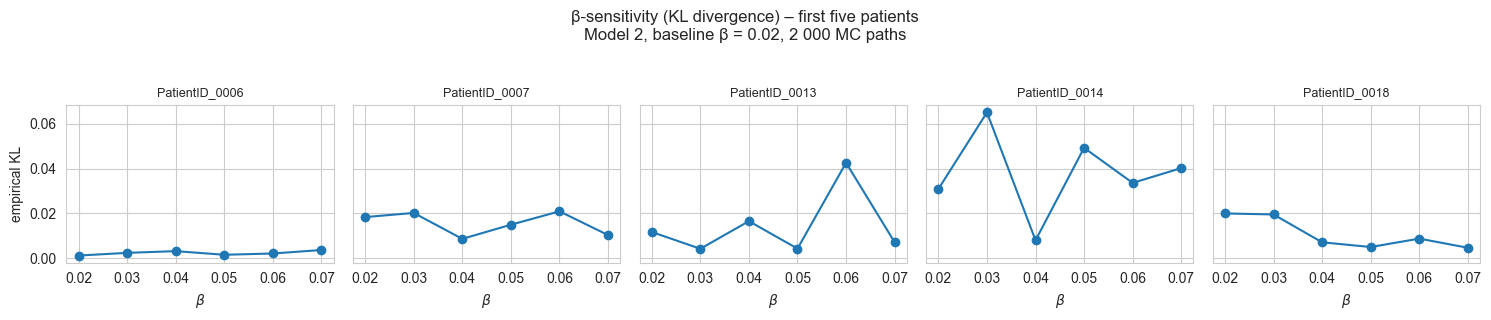

In [21]:
# %% ---------------------------------------------------------------------------
# β-sensitivity (KL divergence) – first five patients, fixed settings
# ---------------------------------------------------------------------------
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import entropy
from itertools import islice

# ------------------------- FIXED SETTINGS ------------------------------------
best_model      = 2                     # keep model 2 for everybody
beta_grid       = np.linspace(0.02, 0.07, 6)    # common sweep
baseline_beta   = 0.02                 # reference β
np.random.seed(42)                     # reproducible Monte-Carlo
N_paths         = 2000                 # smoother KL
T_long, dt_sim  = 200, 0.05            # long run to reach stationarity

# ------------------------- plotting canvas -----------------------------------
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharey=True)

for ax, (pid, (t_obs, y_obs)) in zip(axes, islice(patient_data.items(), 5)):

    # ------ (1) fit Model 2 only -------------------------------------------
    dt_vec      = np.diff(t_obs)
    mle_params, _ = fit_mle_var_dt(y_obs, dt_vec, model=best_model)

    # ------ (2) baseline stationary samples (β = 0.02) ---------------------
    base_params = mle_params.copy()
    base_params[2] = baseline_beta
    base_samples = steady_state_samples(
        baseline_beta, base_params,
        T=T_long, dt=dt_sim, n_paths=N_paths, model=best_model)

    # ------ (3) KL divergence across beta_grid -----------------------------
    kl_vals = []
    hist_base, bin_edges = np.histogram(base_samples, bins=40, density=True)
    eps = 1e-12

    for beta_val in beta_grid:
        test_params = base_params.copy()
        test_params[2] = beta_val
        test_samples = steady_state_samples(
            beta_val, test_params,
            T=T_long, dt=dt_sim, n_paths=N_paths, model=best_model)

        hist_test, _ = np.histogram(test_samples, bins=bin_edges, density=True)
        kl_vals.append(
            entropy(hist_test + eps, hist_base + eps)   # KL(test ‖ baseline)
        )

    # ------ (4) plot --------------------------------------------------------
    ax.plot(beta_grid, kl_vals, marker="o", lw=1.5)
    ax.set_title(pid, fontsize=9)
    ax.set_xlabel(r"$\beta$")
    if ax is axes[0]:
        ax.set_ylabel("empirical KL")
    else:
        ax.set_ylabel("")

plt.suptitle("β-sensitivity (KL divergence) – first five patients\n"
             "Model 2, baseline β = 0.02, 2 000 MC paths", y=1.05)
plt.tight_layout()
plt.show()


C:\Users\yazgha01\AppData\Local\Temp\ipykernel_1876\3920142293.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax[i], x=metric, y=df_delta.index,
C:\Users\yazgha01\AppData\Local\Temp\ipykernel_1876\3920142293.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax[i], x=metric, y=df_delta.index,


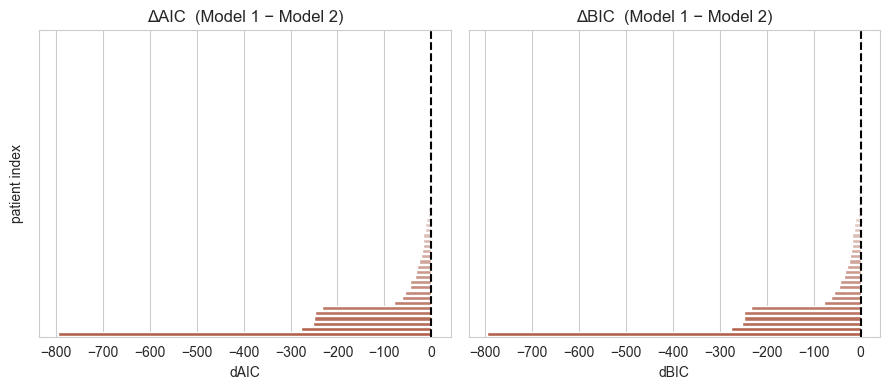

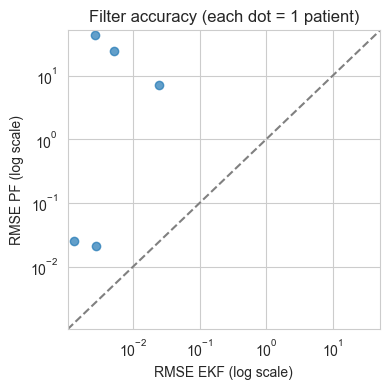

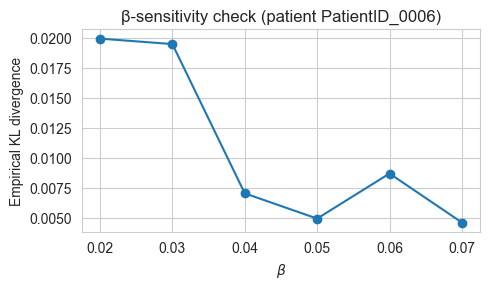

In [24]:
# %% ---------------------------------------------------------------------------
#  Tidy model-validation plots
# ---------------------------------------------------------------------------
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

sns.set_style("whitegrid")

# ---------- ΔAIC / ΔBIC -------------------------------------------------------
deltas = []
for pid, (t_obs, y_obs) in patient_data.items():
    dt_vec = np.diff(t_obs)
    _, nll1 = fit_mle_var_dt(y_obs, dt_vec, model=1)
    _, nll2 = fit_mle_var_dt(y_obs, dt_vec, model=2)
    aic1, bic1 = information_criteria(nll1, 4, len(y_obs))
    aic2, bic2 = information_criteria(nll2, 4, len(y_obs))
    deltas.append(dict(pid=pid, dAIC=aic1-aic2, dBIC=bic1-bic2))

df_delta = (pd.DataFrame(deltas)
              .sort_values("dAIC", ascending=False)
              .reset_index(drop=True))

fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
palette = sns.diverging_palette(220, 20, as_cmap=False, n=len(df_delta))

for i, metric in enumerate(["dAIC", "dBIC"]):
    sns.barplot(ax=ax[i], x=metric, y=df_delta.index,
                data=df_delta, palette=palette, orient="h")
    ax[i].axvline(0, ls="--", c="k")
    ax[i].set_ylabel("patient index")          # keep the axis label
    ax[i].set_xlabel(metric)
    ax[i].set_title(f"Δ{metric[1:]}  (Model 1 − Model 2)")

    # ⬇️  remove the numbers on the y-axis
    ax[i].set_yticklabels([])
    # (optional) also hide the little tick marks:

plt.tight_layout()
plt.show()

# ---------- RMSE: EKF vs PF ---------------------------------------------------
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(df_res.rmse_ekf, df_res.rmse_pf, alpha=0.7)
lims = [min(df_res[["rmse_ekf","rmse_pf"]].min()) * 0.8,
        max(df_res[["rmse_ekf","rmse_pf"]].max()) * 1.2]
ax.set_xscale("log"); ax.set_yscale("log")
ax.plot(lims, lims, ls="--", color="grey")
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel("RMSE EKF (log scale)")
ax.set_ylabel("RMSE PF (log scale)")
ax.set_title("Filter accuracy (each dot = 1 patient)")
plt.tight_layout(); plt.show()

# ---------- β-sensitivity (unchanged) ----------------------------------------
# assumes the previous KL-divergence cell already ran
plt.figure(figsize=(5,3))
plt.plot(beta_grid, kl_vals, marker="o")
plt.xlabel(r"$\beta$"); plt.ylabel("Empirical KL divergence")
plt.title(f"β-sensitivity check (patient {pid0})")
plt.tight_layout(); plt.show()


###  Comparative Analysis Example (first patient)

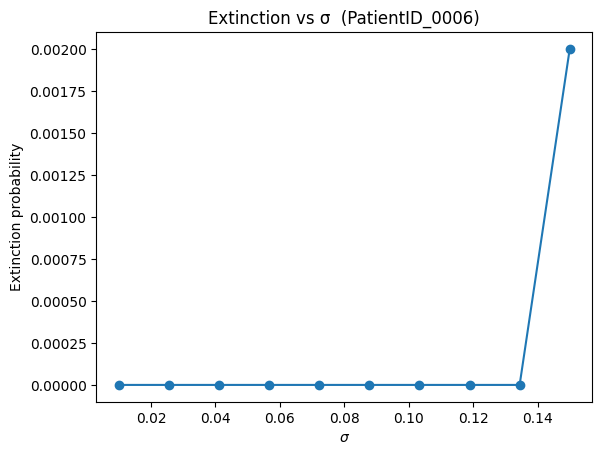

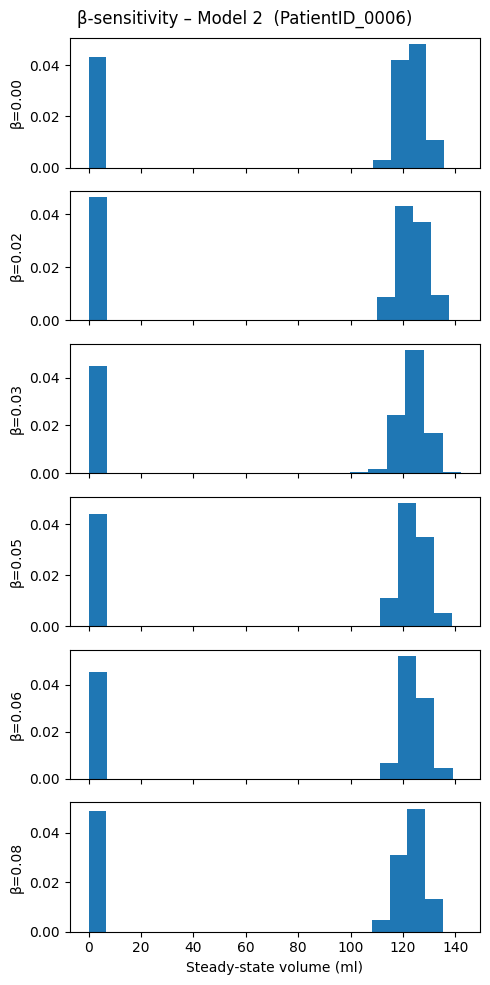

Timing on PatientID_0006: EKF=0.0001s, PF=0.0020s


In [ ]:
# Extinction probability vs σ & β‑sensitivity plots
pid0, (t0, y0) = next(iter(patient_data.items()))
dt_vec0 = np.diff(t0)
best_model0 = df_res.set_index("patient").loc[pid0, "model"]
best_params0 = df_res.set_index("patient").loc[pid0,
               ["mle_a", "mle_b", "mle_beta", "mle_sigma"]].to_numpy(float)

# 5.1 Extinction probability curve
sigma_grid = np.linspace(0.01, 0.15, 10)
p_ext = extinction_probability(best_params0, sigma_grid,
                               model=best_model0, n_paths=500)
plt.figure()
plt.plot(sigma_grid, p_ext, marker="o")
plt.xlabel(r"$\sigma$"); plt.ylabel("Extinction probability")
plt.title(f"Extinction vs σ  ({pid0})")
plt.show()

# 5.2 β‑sensitivity histograms
beta_grid = np.linspace(0.0, 0.08, 6)
fig, ax = plt.subplots(len(beta_grid), 1, figsize=(5, 10), sharex=True)
for i, bet in enumerate(beta_grid):
    samples = steady_state_samples(bet, best_params0,
                                   model=best_model0, n_paths=300)
    ax[i].hist(samples, bins=20, density=True)
    ax[i].set_ylabel(f"β={bet:.2f}")
ax[-1].set_xlabel("Steady‑state volume (ml)")
fig.suptitle(f"β‑sensitivity – Model {best_model0}  ({pid0})")
plt.tight_layout(); plt.show()

# 5.3 Timing EKF vs PF
dt_const0 = np.median(dt_vec0)
t_ekf, t_pf = timing_comparison(y0, dt_const0, best_params0,
                                model=best_model0)
print(f"Timing on {pid0}: EKF={t_ekf:.4f}s, PF={t_pf:.4f}s")

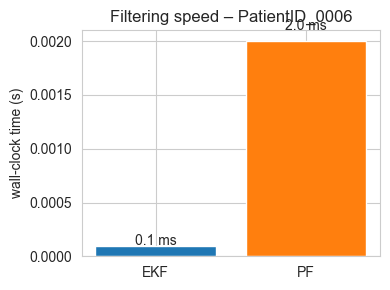

In [ ]:
import matplotlib.pyplot as plt

# Timings you reported
labels  = ["EKF", "PF"]
times_s = [0.0001, 0.0020]          # seconds

plt.figure(figsize=(4,3))
plt.bar(labels, times_s, color=["tab:blue", "tab:orange"])
plt.ylabel("wall-clock time (s)")
plt.title("Filtering speed – PatientID_0006")
for i, t in enumerate(times_s):
    plt.text(i, t*1.05, f"{t*1e3:.1f} ms", ha="center")
plt.tight_layout()
plt.show()
